In [4]:
from sigmoid import fsigmoid
from classifier_sigmoid import mask_negative_data, get_ewma_derivative, get_predicted_flux, get_sigmoid_features_dev
from early_sn_classifier import convert_full_dataset

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
# read data
pdf1 = pd.read_parquet('data/fink_cross_tns_nov2019.parquet')
pdf2 = pd.read_parquet('data/fink_cross_tns_sept2020.parquet')
pdf = pd.concat([pdf1, pdf2], ignore_index=True)

filters = ['g', 'r']

# convert data to appropriate format
lcs = convert_full_dataset(pdf)

In [3]:
# read features
matrix = pd.read_csv('data/features_matrix.csv', index_col=False)

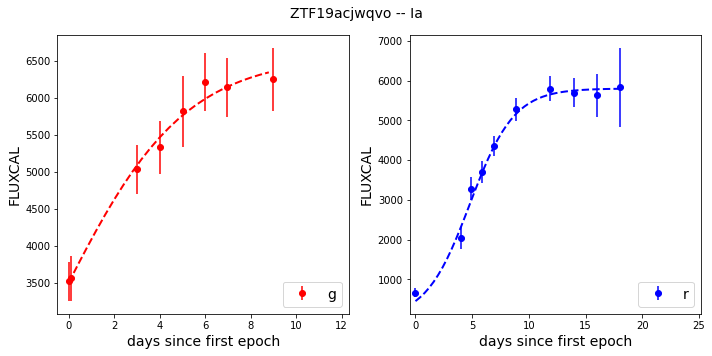

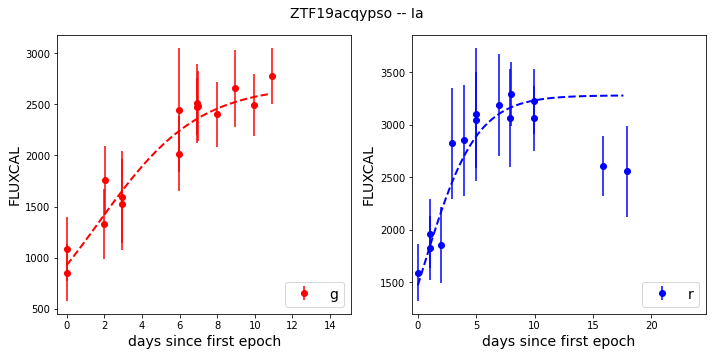

In [6]:
c = ['red', 'blue']

obj_list = ['ZTF19acjwqvo', 'ZTF19acqypso']

for name in obj_list:

    lc_flag = lcs['id'].values == name
    lc_indiv = lcs[lc_flag]

    features_flag = matrix['id'].values == name
    features_indiv = matrix[features_flag]

    plt.figure(figsize=(10,5))
    plt.suptitle(name + ' -- ' + features_indiv['type'].values[0], fontsize=14)

    for f in filters:
        plt.subplot(1,2, filters.index(f) + 1)
        filter_flag = lc_indiv['FLT'].values == f
        lc_filter = lc_indiv[filter_flag]
    
        # compute the derivative
        deriv_ewma = get_ewma_derivative(lc_filter['FLUXCAL'], 3)
        data_masked = lc_filter.mask(deriv_ewma < 0)
        rising_data = data_masked.dropna()
    
        x = np.arange(0, max(rising_data['MJD']) - min(rising_data['MJD']), 0.4)
    
        y = get_predicted_flux(x, features_indiv['a_' + f].values[0], features_indiv['b_' + f].values[0], 
                           features_indiv['c_' + f].values[0]) 
    
        plt.errorbar(rising_data['MJD'] - min(rising_data['MJD']), y=rising_data['FLUXCAL'], yerr=rising_data['FLUXCALERR'], 
                 fmt='o', label=f, color=c[filters.index(f)])
        plt.plot(x, y, ls='--', lw=2, color=c[filters.index(f)])
    
        plt.xlim(-0.5, 1.4*max(x))

        plt.legend(loc='lower right', fontsize=14) 
        plt.xlabel('days since first epoch', fontsize=14)
        plt.ylabel('FLUXCAL', fontsize=14)

    plt.tight_layout()
    plt.savefig('plots/LC_' + name + '.png')